# 1D and 3D examples (using GMesh files)
In this example we use pygmsh to construct a tetrahedral mesh and olve a
simple laplace problem

In [1]:
import numpy, math
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
from matplotlib import pyplot
from dune.alugrid import aluSimplexGrid as leafGridView3d
from dune.grid import OutputType
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
from ufl import TestFunction, TrialFunction, SpatialCoordinate
from ufl import dx, grad, grad, dot, inner, conditional, sin

# The following code is taken from the `pygmsh` homepage
try:
    import pygmsh
    with pygmsh.geo.Geometry() as geom:
        poly = geom.add_polygon([
              [ 0.0,  0.5, 0.0], [-0.1,  0.1, 0.0], [-0.5,  0.0, 0.0],
              [-0.1, -0.1, 0.0], [ 0.0, -0.5, 0.0], [ 0.1, -0.1, 0.0],
              [ 0.5,  0.0, 0.0], [ 0.1,  0.1, 0.0] ], mesh_size=0.05)
        geom.twist(
            poly,
            translation_axis=[0, 0, 1], rotation_axis=[0, 0, 1], point_on_axis=[0, 0, 0],
            angle=numpy.pi / 3,
        )
        mesh = geom.generate_mesh(verbose=False)

    points, cells = mesh.points, mesh.cells_dict
    domain3d = {"vertices":points.astype("float"), "simplices":cells["tetra"]}
except ImportError: # pygmsh not installed - use a simple cartesian domain
    print("pygmsh module not found using a simple Cartesian domain - ignored")
    from dune.grid import cartesianDomain
    domain3d = cartesianDomain([-0.25,-0.25,0],[0.25,0.25,1],[30,30,60])

gridView3d  = leafGridView3d(domain3d)
space3d = solutionSpace(gridView3d, order=1)

u = TrialFunction(space3d)
v = TestFunction(space3d)
x = SpatialCoordinate(space3d)
scheme3d = solutionScheme((inner(grad(u),grad(v))+inner(u,v))*dx ==
                        conditional(dot(x,x)<.01,100,0)*v*dx,
                        solver='cg')

uh3d = space3d.interpolate([0],name="solution")
scheme3d.solve(target=uh3d)
# note: plotting with matplotlib not yet available for 3d grids
gridView3d.writeVTK('3dexample', pointdata=[uh3d],
                    outputType=OutputType.appendedraw)

![3d laplace problem](figures/3dexample.png)

We can also do 1D

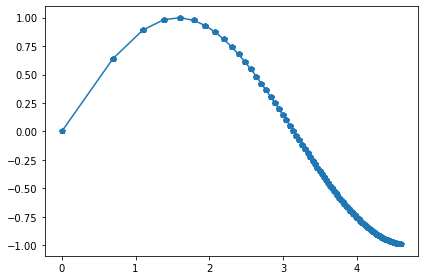

In [2]:
from dune.grid import onedGrid
v = [math.log(i) for i in range(1,100)]
e = [(i,i+1) for i in range(1,len(v))]
g = onedGrid(constructor={"vertices":v, "simplices":e})
s = solutionSpace(g)
x = SpatialCoordinate(s)
u = s.interpolate(sin(x[0]), name="u")
u.plot()

pyplot can very easily be used in 1d:
pyplot.plot(g.tesselate()[0], u.pointData(), '-p')